In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.4.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


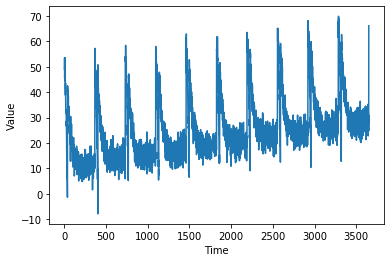

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: 100*x)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule],verbose=0)

[1e-08, 0.0001, 0, 30]

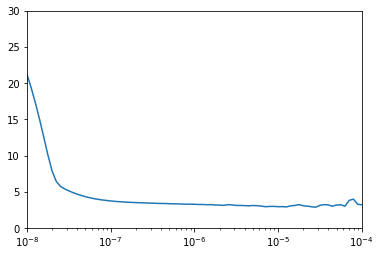

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

# FROM THIS PICK A LEARNING RATE

In [7]:
from math import exp
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.05
    lrate = initial_lrate * exp(-k*epoch)
    return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(exp_decay)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: 100*x)
])

model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=300,verbose=2, callbacks=[lrate])
                                                            
# FIND A MODEL AND A LR THAT TRAINS TO AN MAE < 3                                                          

Epoch 1/300
94/94 - 4s - loss: 12.6974 - mae: 13.1875
Epoch 2/300
94/94 - 1s - loss: 6.4042 - mae: 6.8865
Epoch 3/300
94/94 - 1s - loss: 7.3623 - mae: 7.8472
Epoch 4/300
94/94 - 1s - loss: 7.7467 - mae: 8.2315
Epoch 5/300
94/94 - 1s - loss: 6.3066 - mae: 6.7904
Epoch 6/300
94/94 - 1s - loss: 3.9684 - mae: 4.4434
Epoch 7/300
94/94 - 1s - loss: 4.3860 - mae: 4.8660
Epoch 8/300
94/94 - 1s - loss: 3.9747 - mae: 4.4509
Epoch 9/300
94/94 - 1s - loss: 4.1419 - mae: 4.6174
Epoch 10/300
94/94 - 1s - loss: 4.3522 - mae: 4.8274
Epoch 11/300
94/94 - 1s - loss: 3.8742 - mae: 4.3473
Epoch 12/300
94/94 - 1s - loss: 3.8426 - mae: 4.3152
Epoch 13/300
94/94 - 1s - loss: 3.0816 - mae: 3.5467
Epoch 14/300
94/94 - 1s - loss: 3.4585 - mae: 3.9284
Epoch 15/300
94/94 - 1s - loss: 3.3728 - mae: 3.8398
Epoch 16/300
94/94 - 1s - loss: 3.9538 - mae: 4.4303
Epoch 17/300
94/94 - 1s - loss: 3.5853 - mae: 4.0578
Epoch 18/300
94/94 - 1s - loss: 3.3680 - mae: 3.8388
Epoch 19/300
94/94 - 1s - loss: 3.3089 - mae: 3.7790


Epoch 155/300
94/94 - 1s - loss: 2.5045 - mae: 2.9644
Epoch 156/300
94/94 - 1s - loss: 2.5048 - mae: 2.9650
Epoch 157/300
94/94 - 1s - loss: 2.5043 - mae: 2.9642
Epoch 158/300
94/94 - 1s - loss: 2.5044 - mae: 2.9644
Epoch 159/300
94/94 - 1s - loss: 2.5044 - mae: 2.9644
Epoch 160/300
94/94 - 1s - loss: 2.5048 - mae: 2.9649
Epoch 161/300
94/94 - 1s - loss: 2.5041 - mae: 2.9641
Epoch 162/300
94/94 - 1s - loss: 2.5043 - mae: 2.9641
Epoch 163/300
94/94 - 1s - loss: 2.5053 - mae: 2.9654
Epoch 164/300
94/94 - 1s - loss: 2.5044 - mae: 2.9645
Epoch 165/300
94/94 - 1s - loss: 2.5038 - mae: 2.9638
Epoch 166/300
94/94 - 1s - loss: 2.5042 - mae: 2.9640
Epoch 167/300
94/94 - 1s - loss: 2.5042 - mae: 2.9643
Epoch 168/300
94/94 - 1s - loss: 2.5047 - mae: 2.9645
Epoch 169/300
94/94 - 1s - loss: 2.5039 - mae: 2.9639
Epoch 170/300
94/94 - 1s - loss: 2.5041 - mae: 2.9641
Epoch 171/300
94/94 - 1s - loss: 2.5041 - mae: 2.9641
Epoch 172/300
94/94 - 1s - loss: 2.5037 - mae: 2.9636
Epoch 173/300
94/94 - 1s - l

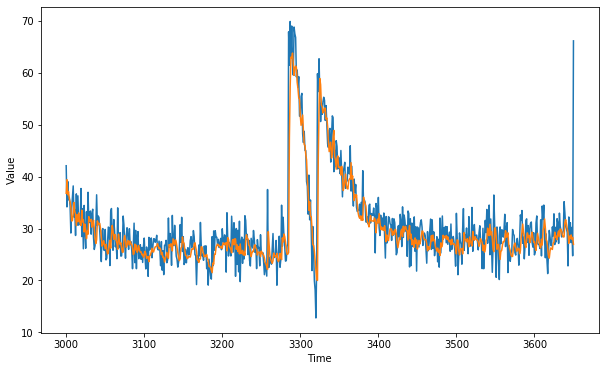

In [8]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

# YOUR RESULT HERE SHOULD BE LESS THAN 4

2.9976718

<Figure size 432x288 with 0 Axes>

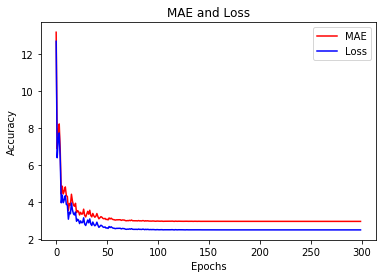

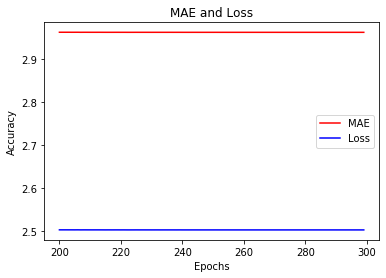

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()